In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

2.8.0


### Club all the traces together into a single dataframe

In [2]:
path = './traces/'# use your path
#all_files = glob.glob(path + "/*.h5")
all_files = glob.glob(path + "/demo_new-*.prof.h5")

li = []

for filename in all_files:
    trace =  pd.HDFStore(filename)
    data = trace.get('/events')
    informations = trace.get('/information')
    trace.close()
    
    li.append(data)

df = pd.concat(li, axis=0, ignore_index=True)


In [3]:
#print(informations)

In [4]:
print(df.head())
print(df.shape)

  total_data_size node_id chore_id stream_id taskpool_id flags   id priority  \
0               0       0        0         0           2     1    0       -1   
1               0       0        0         0           2     1    0       -1   
2         5120000       0        0         0           2     1    0        0   
3         5120000       0        0         0           2     1   75        0   
4         5120000       0        0         0           2     1  225        0   

  task_class_id type     begin       end nb_data_items msg_size  dst tcid  \
0             5    3     62124     65845             0      NaN  NaN  NaN   
1             4    3     67998   1295023             0      NaN  NaN  NaN   
2             1    3   1299741   8685016             2      NaN  NaN  NaN   
3             1    3   8691619  16162607             2      NaN  NaN  NaN   
4             1    3  16168584  24182129             2      NaN  NaN  NaN   

  tpid  src  tid  
0  NaN  NaN  NaN  
1  NaN  NaN  NaN  

# Clean the data

In [5]:
#remove info from other traces
df_refined = df[['begin', 'end', 'taskpool_id', 'task_class_id','chore_id', 'nb_data_items', 'total_data_size', 'priority']].copy()
df_refined['exec_time'] = (df['end'] - df['begin']) * .001 #0.001 nano seconds to micro seconds


In [6]:
df_class_name = {0: 'dpotrf', 1: 'dtrsm', 2: 'dsyrk', 3: 'dgemm'}

In [7]:
filter = ( (df_refined['task_class_id'] >= 0 ) & ( df_refined['task_class_id'] <= 3 ) & ( df_refined['priority'] >= 0 ) )
#remove all other classes other than dpotrf, dgemm, trsm and syrk
df_refined = df_refined[filter]
df_refined.head()

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,exec_time
2,1299741,8685016,2,1,0,2,5120000,0,7385.275
3,8691619,16162607,2,1,0,2,5120000,0,7470.988
4,16168584,24182129,2,1,0,2,5120000,0,8013.545
5,24188601,31603277,2,1,0,2,5120000,0,7414.676
6,31609242,39493451,2,1,0,2,5120000,0,7884.209


In [8]:
print(df_refined['task_class_id'].unique())

[1 2 3 0]


In [9]:
df_class = {}
for i in df_refined['task_class_id'].unique():
    df_class[i] = df_refined[df_refined['task_class_id'] == i]
    

In [10]:
#df_class[3][df_class[3]['total_data_size'] == 0]#.total_data_size

In [11]:
#df_class[3].tail()

<Figure size 432x288 with 0 Axes>

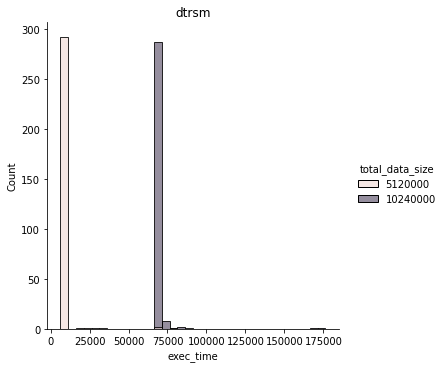

<Figure size 432x288 with 0 Axes>

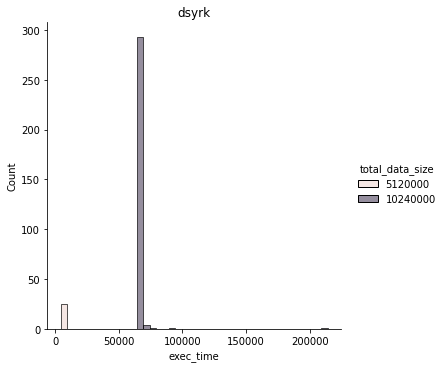

<Figure size 432x288 with 0 Axes>

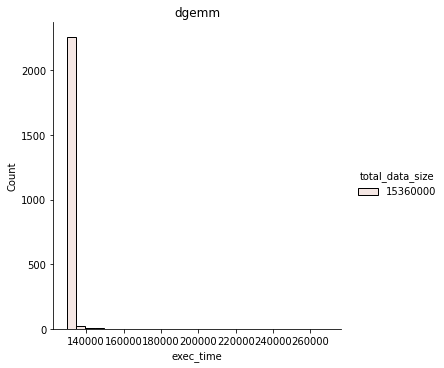

<Figure size 432x288 with 0 Axes>

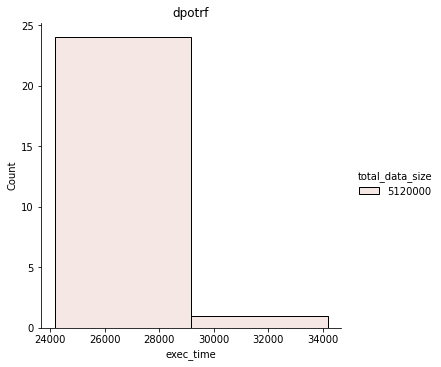

In [12]:
for i in df_refined['task_class_id'].unique():
    title = df_class_name[i]
    plt.figure()
    sns.displot(df_class[i], x="exec_time", hue='total_data_size', binwidth=5e3)
    plt.title(title)
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seab

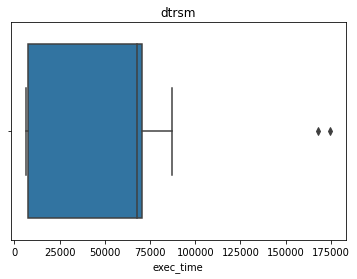

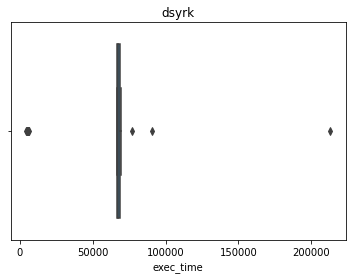

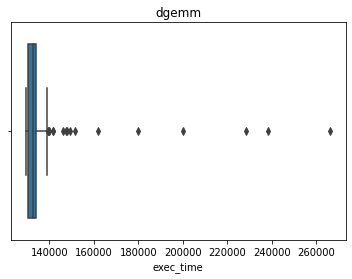

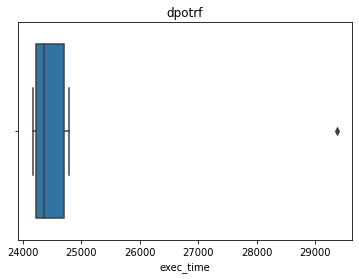

In [13]:
for i in df_refined['task_class_id'].unique():
    title = df_class_name[i]
    plt.figure()
    sns.boxplot(df_class[i]['exec_time'])
    plt.title(title)
plt.show()

# After removing outliers

In [14]:
#Q1 = one_class_only['exec_time'].quantile(0.25)
#Q3 = one_class_only['exec_time'].quantile(0.75)
#IQR = Q3 - Q1    #IQR is interquartile range.

#filter = (one_class_only['exec_time'] >= Q1 - 1.5 * IQR) & (one_class_only['exec_time'] <= Q3 + 1.5 *IQR)
#one_class_only = one_class_only.loc[filter]


<Figure size 432x288 with 0 Axes>

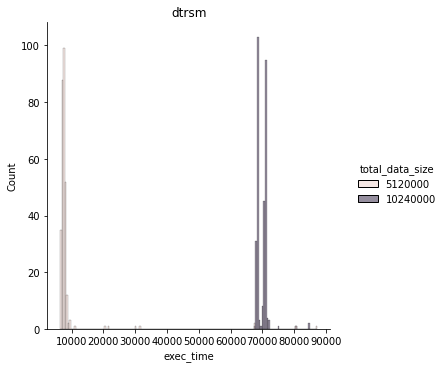

<Figure size 432x288 with 0 Axes>

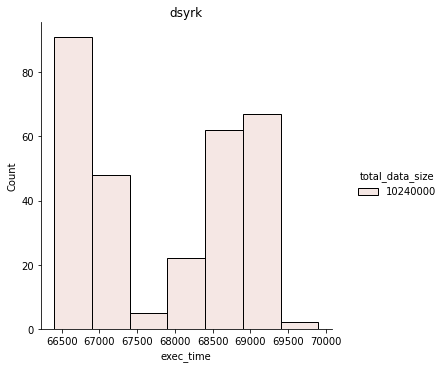

<Figure size 432x288 with 0 Axes>

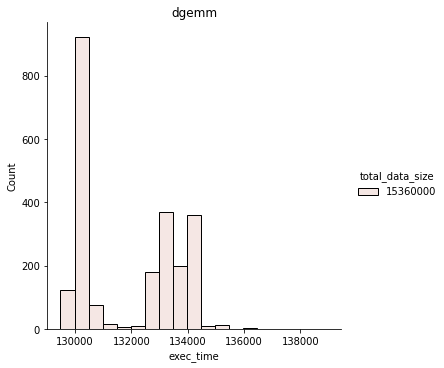

<Figure size 432x288 with 0 Axes>

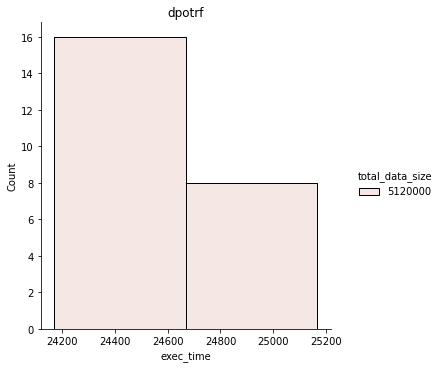

In [271]:
for i in df_refined['task_class_id'].unique():
    title = df_class_name[i]
    Q1 = df_class[i]['exec_time'].quantile(0.25)
    Q3 = df_class[i]['exec_time'].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.
    filter = (df_class[i]['exec_time'] >= Q1 - 1.5 * IQR) & (df_class[i]['exec_time'] <= Q3 + 1.5 *IQR)
    df_new = df_class[i].loc[filter]
    plt.figure()
    sns.displot(df_new, x="exec_time", hue='total_data_size', binwidth=5e2)
    plt.title(title)
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seab

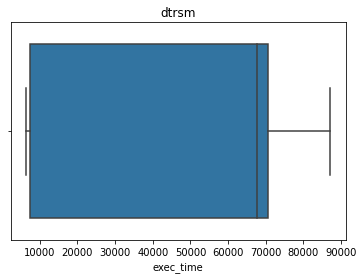

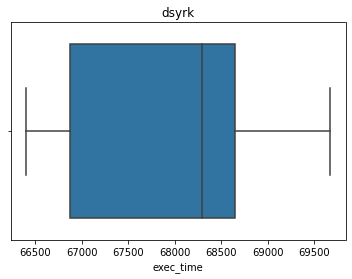

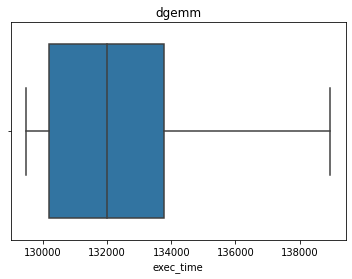

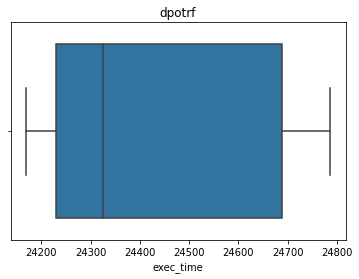

In [272]:
for i in df_refined['task_class_id'].unique():
    title = df_class_name[i]
    Q1 = df_class[i]['exec_time'].quantile(0.25)
    Q3 = df_class[i]['exec_time'].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.
    filter = (df_class[i]['exec_time'] >= Q1 - 1.5 * IQR) & (df_class[i]['exec_time'] <= Q3 + 1.5 *IQR)
    df_new = df_class[i].loc[filter]
    plt.figure()
    sns.boxplot(df_new['exec_time'])
    plt.title(title)
plt.show()